# Demo - Black Box Attack (CIFAR10)

In [1]:
import os
import sys
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

import torchvision.utils
from torchvision import models
import torchvision.datasets as dsets
import torchvision.transforms as transforms

import torchattacks
from torchattacks import PGD

from models import Holdout, Target
from utils import imshow

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline

## 1. Load Data

In [3]:
batch_size = 24

cifar10_train = dsets.CIFAR10(root='./data', train=True,
                              download=True, transform=transforms.ToTensor())
cifar10_test  = dsets.CIFAR10(root='./data', train=False,
                              download=True, transform=transforms.ToTensor())

train_loader = torch.utils.data.DataLoader(cifar10_train,
                                           batch_size=batch_size,
                                           shuffle=True)
test_loader = torch.utils.data.DataLoader(cifar10_test,
                                          batch_size=batch_size,
                                          shuffle=False)

Files already downloaded and verified
Files already downloaded and verified


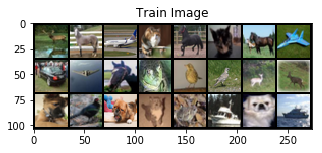

In [4]:
images, labels = iter(train_loader).next()
imshow(torchvision.utils.make_grid(images, normalize=True), "Train Image")

## 2. Load Holdout Model & Save Adversarial Images

In [5]:
model = Holdout()
model.load_state_dict(torch.load("./model/holdout.pth"))
model = model.eval().cuda()

In [6]:
pgd_attack = PGD(model, eps=8/255, alpha=2/255, steps=7)
pgd_attack.set_return_type('int') # Save as integer.
pgd_attack.save(data_loader=test_loader, save_path="./data/cifar10_pgd.pt", verbose=True)

- Save Progress : 100.00 % / Accuracy : 0.22 %
- Save Complete!


## 3. Load Adversarial Images

In [7]:
adv_images, adv_labels = torch.load("./data/cifar10_pgd.pt")
adv_data = TensorDataset(adv_images.float()/255, adv_labels)
adv_loader = DataLoader(adv_data, batch_size=128, shuffle=False)

## 4. Attack Target Model

In [8]:
model = Target().cuda()
model.load_state_dict(torch.load("./model/target.pth"))

<All keys matched successfully>

### 4.1 Clean Accuracy

In [9]:
model.eval()

correct = 0
total = 0

for images, labels in test_loader:
    
    images = images.cuda()
    outputs = model(images)
    
    _, predicted = torch.max(outputs.data, 1)
    
    total += labels.size(0)
    correct += (predicted == labels.cuda()).sum()
    
print('Standard accuracy: %.2f %%' % (100 * float(correct) / total))

Standard accuracy: 87.26 %


### 4.2 Robust Accuracy

In [10]:
model.eval()

correct = 0
total = 0

for images, labels in adv_loader:
    
    images = images.cuda()
    outputs = model(images)
    
    _, predicted = torch.max(outputs.data, 1)
    
    total += labels.size(0)
    correct += (predicted == labels.cuda()).sum()
    
print('Robust accuracy: %.2f %%' % (100 * float(correct) / total))

Robust accuracy: 63.75 %
